<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
!git clone https://github.com/ChrisWaites/pyvacy
!pip install diffprivlib
%ls

Cloning into 'pyvacy'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 81 (delta 7), reused 22 (delta 5), pack-reused 54
Unpacking objects: 100% (81/81), done.
     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for diffprivlib: filename=diffprivlib-0.3.0-cp36-none-any.whl size=138999 sha256=8a94a3517fe91dc1a701f2f86640ee78d5a3a8e326d2807fff77ac82f56e070a
  Stored in directory: /root/.cache/pip/wheels/64/68/62/617183f73d3feceab2c9d4081714a27bc11be5bb3f10f59b8a
Successfully built diffprivlib
pyvacy/  sample_data/


In [2]:
%cd pyvacy
%run setup.py install


/content/pyvacy
running install
running bdist_egg
running egg_info
creating pyvacy.egg-info
writing pyvacy.egg-info/PKG-INFO
writing dependency_links to pyvacy.egg-info/dependency_links.txt
writing requirements to pyvacy.egg-info/requires.txt
writing top-level names to pyvacy.egg-info/top_level.txt
writing manifest file 'pyvacy.egg-info/SOURCES.txt'
writing manifest file 'pyvacy.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pyvacy
copying pyvacy/__init__.py -> build/lib/pyvacy
creating build/lib/pyvacy/analysis
copying pyvacy/analysis/rdp_accountant.py -> build/lib/pyvacy/analysis
copying pyvacy/analysis/subsampled.py -> build/lib/pyvacy/analysis
copying pyvacy/analysis/epsilon_calculation.py -> build/lib/pyvacy/analysis
copying pyvacy/analysis/__init__.py -> build/lib/pyvacy/analysis
copying pyvacy/analysis/moments_accountant.py -> build/lib/pyvacy/analysis
creatin

zip_safe flag not set; analyzing archive contents...


creating dist
creating 'dist/pyvacy-0.0.1-py3.6.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing pyvacy-0.0.1-py3.6.egg
Copying pyvacy-0.0.1-py3.6.egg to /usr/local/lib/python3.6/dist-packages
Adding pyvacy 0.0.1 to easy-install.pth file

Installed /usr/local/lib/python3.6/dist-packages/pyvacy-0.0.1-py3.6.egg
Processing dependencies for pyvacy==0.0.1
Searching for torch-vision
Reading https://pypi.org/simple/torch-vision/
Best match: torch-vision 0.1.6.dev0
Processing torch_vision-0.1.6.dev0-py2.py3-none-any.whl
Installing torch_vision-0.1.6.dev0-py2.py3-none-any.whl to /usr/local/lib/python3.6/dist-packages
Adding torch-vision 0.1.6.dev0 to easy-install.pth file

Installed /usr/local/lib/python3.6/dist-packages/torch_vision-0.1.6.dev0-py3.6.egg
Searching for torch==1.6.0+cu101
Best match: torch 1.6.0+cu101
Adding torch 1.6.0+cu101 to easy-install.pth file
Installing convert-caffe2-to-onnx script to /usr/l

In [3]:
import diffprivlib
import sys

import argparse
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

from pyvacy import optim, analysis, sampling
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


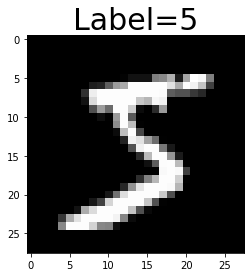

In [ ]:
train_dataset = datasets.MNIST('data/mnist',
        train=True,
        download=True,
        transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,))]))#.train_data



X = train_dataset.train_data.view(-1, 28*28)
y = train_dataset.targets

plt.title(f'Label={y[0]}', size=30)
plt.imshow(X[0].view(28, 28), cmap='gray');

In [ ]:
dataset = datasets.MNIST('data/mnist',
        train=False,
        download=True,
        transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,))]))

dataset.data.shape

torch.Size([10000, 28, 28])

In [27]:
def mnist_private_pca(epsilon=4):
    train = datasets.MNIST('data/mnist',
            train=True,
            download=True,
            transform=transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))]))#.train_data

    test = datasets.MNIST('data/mnist',
            train=False,
            download=True,
            transform=transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))]))#.train_data

    X_train = train.data.view(-1, 28*28)
    y_train = train.targets

    X_test = test.data.view(-1, 28*28)
    y_test = test.targets

    DPPCA = diffprivlib.models.pca.PCA(n_components=30,centered=True, epsilon=epsilon)
    X_train_pc = DPPCA.fit_transform(X_train)
    X_train_pc = torch.Tensor(X_train_pc).view(-1, 30)

    X_test_pc = DPPCA.transform(X_test)
    X_test_pc = torch.Tensor(X_test_pc).view(-1, 30)
    return X_train_pc, y_train, X_test_pc, y_test




In [28]:
import tqdm

class simpleClf(nn.Module):
    def __init__(self, device='cpu'):
        super(simpleClf, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.model(x)

def train(dataset, optimizer, clf, loss_function, params):

    minibatch_loader, microbatch_loader = sampling.get_data_loaders(
          params['minibatch_size'],
          params['microbatch_size'],
          params['iterations']
      )

    iteration = 0
    for X_minibatch, y_minibatch in minibatch_loader(dataset):
      optimizer.zero_grad()
      # running_loss = 0
      for X_microbatch, y_microbatch in microbatch_loader(TensorDataset(X_minibatch, y_minibatch)):
          X_microbatch = X_microbatch.to(params['device'])
          y_microbatch = y_microbatch.to(params['device'])

          optimizer.zero_microbatch_grad()
          prediction = clf(X_microbatch)
          loss = loss_function(prediction, y_microbatch)

          loss.backward()
          optimizer.microbatch_step()
          # running_loss += loss.item()
      optimizer.step()

      if iteration % 10 == 0:
        print('[Iteration %d/%d] [Loss: %f]' % (iteration, params['iterations'], loss.item()))
      iteration += 1

In [30]:
params = {
    'delta': 1e-5,
    'device': 'cpu',
    'iterations': 1000,
    'l2_norm_clip': 4.,
    'l2_penalty': 0.001,
    'lr': 0.001,
    'microbatch_size': 1,
    'minibatch_size': 100,
    'noise_multiplier': 2
}

X_train, y_train, X_test, y_test = mnist_private_pca(epsilon=100)
mnist_train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=params['minibatch_size'], shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=True)
model = simpleClf()
criterion = nn.NLLLoss()
optimizer = optim.DPSGD(
        l2_norm_clip=params['l2_norm_clip'],
        noise_multiplier=params['noise_multiplier'],
        minibatch_size=params['minibatch_size'],
        microbatch_size=params['microbatch_size'],
        params=model.parameters(),
        lr=params['lr'],
        weight_decay=params['l2_penalty'],
    )

print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train),
        params['minibatch_size'],
        params['noise_multiplier'],
        params['iterations'],
        params['delta']
    ),
    params['delta'],
))

train(
    TensorDataset(X_train, y_train),
    optimizer=optimizer,
    clf=model,
    loss_function=criterion,
    params=params
    )

with torch.no_grad():
    logps = model(X_test.view(-1, 30))
print(f"Accuracy: {round(((torch.exp(logps).argmax(dim=1) == y_test).sum().float()/len(X_test)*100).item(), 2)}%")

/usr/local/lib/python3.6/dist-packages/diffprivlib/models/pca.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)


Achieves (0.25359886466248716, 1e-05)-DP
[Iteration 0/1000] [Loss: 306.399628]
[Iteration 10/1000] [Loss: 101.116196]
[Iteration 20/1000] [Loss: 0.000000]
[Iteration 30/1000] [Loss: 2.971449]
[Iteration 40/1000] [Loss: 69.031860]
[Iteration 50/1000] [Loss: 183.675049]
[Iteration 60/1000] [Loss: 140.568817]
[Iteration 70/1000] [Loss: 55.080872]
[Iteration 80/1000] [Loss: 43.892044]
[Iteration 90/1000] [Loss: 77.570549]
[Iteration 100/1000] [Loss: 121.239380]
[Iteration 110/1000] [Loss: 0.000130]
[Iteration 120/1000] [Loss: 60.312683]
[Iteration 130/1000] [Loss: 134.286362]
[Iteration 140/1000] [Loss: 137.063995]
[Iteration 150/1000] [Loss: 116.185661]
[Iteration 160/1000] [Loss: 77.205399]
[Iteration 170/1000] [Loss: 88.725021]
[Iteration 180/1000] [Loss: 0.000000]
[Iteration 190/1000] [Loss: 48.423183]
[Iteration 200/1000] [Loss: 226.825684]
[Iteration 210/1000] [Loss: 7.863688]
[Iteration 220/1000] [Loss: 29.086082]
[Iteration 230/1000] [Loss: 51.406662]
[Iteration 240/1000] [Loss: 45

In [6]:
X_train, y_train, X_test, y_test = mnist_private_pca(epsilon=100)
mnist_train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=True)
model = simpleClf()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

train(
    mnist_train_loader,
    optimizer=optimizer,
    clf=model,
    loss_function=criterion,
    epochs=5
    )

with torch.no_grad():
    logps = model(X_test.view(-1, 60))
print(f"Accuracy: {round(((torch.exp(logps).argmax(dim=1) == y_test).sum().float()/len(X_test)*100).item(), 2)}%")

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/diffprivlib/models/pca.py:223: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)


Training loss:  1.9632931491300496
Training loss:  0.38076825829834415
Training loss:  0.27597156134563117
Training loss:  0.22665516893143084
Training loss:  0.19929648255969065
Accuracy: 94.45%


In [ ]:
import numpy as np

def test_pca():
    epsilons = np.linspace(0.00001, 10000, 9)
    accuracies = []
    for e in epsilons:
        X_train, y_train, X_test, y_test = mnist_private_pca(epsilon=e)
        mnist_train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
        mnist_test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=True)
        model = simpleClf()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001)

        train(
            mnist_train_loader,
            optimizer=optimizer,
            clf=model,
            loss_function=criterion,
            epochs=5
            )

        with torch.no_grad():
            logps = model(X_test.view(-1, 60))
        accuracies.append(round(((torch.exp(logps).argmax(dim=1) == y_test).sum().float()/len(X_test)*100).item(), 2))
    return epsilons, accuracies

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

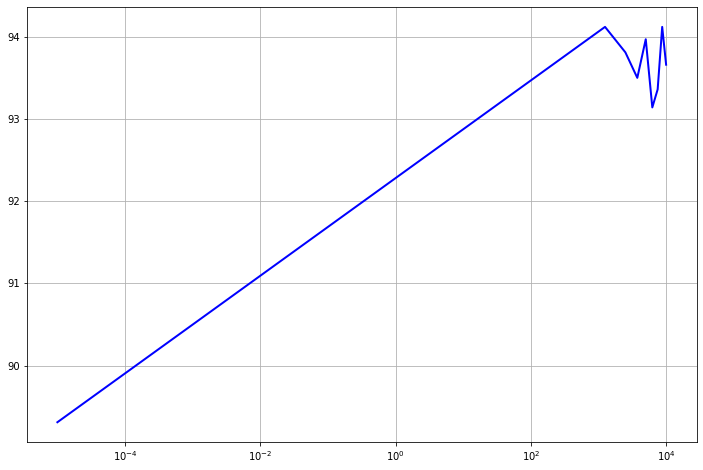

In [ ]:


# eps, acc = test_pca()
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(eps, acc, color='blue', lw=2)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.grid()
plt.show()

In [ ]:
X[0].shape

torch.Size([1, 60])

In [ ]:
import time
l = tqdm.tqdm((X, y))
for (x, y) in l:
    time.sleep(0.1)



  0%|          | 0/2 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
import sys

import argparse
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

from pyvacy import optim, analysis, sampling


# Deterministic output
torch.manual_seed(0)
np.random.seed(0)

class Flatten(nn.Module):
    def forward(self, inp):
        return inp.reshape(inp.shape[0], -1)

class Classifier(nn.Module):
    def __init__(self, input_dim, device='cpu'):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 8, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.Conv2d(16, 32, 4, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            Flatten(),
            nn.Linear(288, 10),
            nn.LogSoftmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.model(x)

class simpleClf(nn.Module):
    def __init__(self, input_dim, device='cpu'):
        super(simpleClf, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(60, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            nn.LogSoftmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.model(x)


def train(params):
    # train_dataset = datasets.MNIST('data/mnist',
    #     train=True,
    #     download=True,
    #     transform=transforms.Compose([
    #        transforms.ToTensor(),
    #        transforms.Normalize((0.5,), (0.5,))
    #     ])
    # )
    train_dataset = Xp

    classifier = simpleClf(
        # input_dim=np.prod(train_dataset[0][0].shape),
        input_dim = 60,
        device=params['device']
    )

    optimizer = optim.DPSGD(
        l2_norm_clip=params['l2_norm_clip'],
        noise_multiplier=params['noise_multiplier'],
        minibatch_size=params['minibatch_size'],
        microbatch_size=params['microbatch_size'],
        params=classifier.parameters(),
        lr=params['lr'],
        weight_decay=params['l2_penalty'],
    )

    print('Achieves ({}, {})-DP'.format(
        analysis.epsilon(
            len(train_dataset),
            params['minibatch_size'],
            params['noise_multiplier'],
            params['iterations'],
            params['delta']
        ),
        params['delta'],
    ))

    loss_function = nn.NLLLoss()

    minibatch_loader, microbatch_loader = sampling.get_data_loaders(
        params['minibatch_size'],
        params['microbatch_size'],
        params['iterations']
    )

    iteration = 0
    for X_minibatch, y_minibatch in minibatch_loader(TensorDataset(Xp, y)):
    # for X_minibatch, y_minibatch in minibatch_loader(train_dataset):

        optimizer.zero_grad()
        for X_microbatch, y_microbatch in microbatch_loader(TensorDataset(X_minibatch, y_minibatch)):
            X_microbatch = X_microbatch.to(params['device'])
            y_microbatch = y_microbatch.to(params['device'])
  
            optimizer.zero_microbatch_grad()
            pred = classifier(X_microbatch)#.argmax(dim=2)
            print(X_microbatch, pred, y_microbatch)
            loss = loss_function(pred.view(1, 10).float(), y_microbatch)
            print(loss)
            break
            loss.backward()
            optimizer.microbatch_step()
        optimizer.step()

        if iteration % 10 == 0:
            print('[Iteration %d/%d] [Loss: %f]' % (iteration, params['iterations'], loss.item()))
        iteration += 1

    return classifier



params = {
'delta': 1e-5,
'device': 'cpu',
'iterations': 14000,
'l2_norm_clip': 1.,
'l2_penalty':0.001, 
'lr': 0.15,
'microbatch_size':1,
'minibatch_size':256,
'noise_multiplier':1.1}

classifier = train(params)

with open('dp_classifier.dat', 'wb') as f:
    torch.save(classifier, f)

test_dataset = datasets.MNIST('data/mnist',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

X, y = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))
X, y  = X.to('cuda'), y.to('cuda')

y_pred = classifier(X).max(1)[1]

count = 0.
correct = 0.
for pred, actual in zip(y_pred, y):
    if pred.item() == actual.item():
        correct += 1.
    count += 1.
print('Test Accuracy: {}'.format(correct / count))


Achieves (3.001484703654448, 1e-05)-DP
tensor([[[1687.8270,  -27.6370, -234.4076, -266.1989,  458.8726, -459.3125,
            49.4550,  414.9841,   73.7365,  257.8884, -417.3697,    8.5458,
          -151.2217, -264.7183, -273.7069,  163.3416,  429.3411,   64.4026,
           -33.8287, -201.7081, -459.6727,   55.5027, -326.0295,  379.1437,
           334.2971,  -85.1494,  -64.2280,  -77.3139, -160.3390,   75.2707,
            -6.2583,  186.5017, -142.1675,  170.6958, -424.6932, -121.7693,
           135.5125,  119.6756,  158.1014,  -14.2701, -186.3714,  -91.5073,
          -241.6966,   37.4189,   43.8015,   49.5008,   84.6287,   84.7137,
            69.4251, -174.8053,   78.0787,  151.1046, -124.2576,   47.2992,
           -38.6829,  -30.3598,  146.3357,   48.1629,   84.9712,  -60.5954]]]) tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<LogSoftmaxBackward>) tensor([3])
tensor(0., grad_fn=<NllLossBackward>)


AttributeError: ignored

NameError: ignored

In [ ]:
[]

tensor(0.)

In [ ]:
    minibatch_loader, microbatch_loader = sampling.get_data_loaders(
        params['minibatch_size'],
        params['microbatch_size'],
        params['iterations']
    )
train_dataset = datasets.MNIST('data/mnist',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))]))
    



    for X_minibatch, y_minibatch in minibatch_loader(train_dataset):
        print(X_minibatch.shape, y_minibatch.shape)
        for X_microbatch, y_microbatch in microbatch_loader(TensorDataset(X_minibatch, y_minibatch)):
            print(X_microbatch.shape, y_microbatch.shape)
            break
        break



torch.Size([281, 1, 28, 28]) torch.Size([281])
torch.Size([1, 1, 28, 28]) torch.Size([1])


In [ ]:
train_dataset.train_data[0]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
!git clone https://github.com/ChrisWaites/pyvacy
!pip install diffprivlib
%ls

Cloning into 'pyvacy'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 81 (delta 7), reused 22 (delta 5), pack-reused 54
Unpacking objects: 100% (81/81), done.
     |████████████████████████████████| 71kB 1.9MB/s 
  Created wheel for diffprivlib: filename=diffprivlib-0.3.0-cp36-none-any.whl size=138999 sha256=ba4fd7afec58ecd73ec840e24e01d1d22f6632987abba35e5bf353dc3674ef1a
  Stored in directory: /root/.cache/pip/wheels/64/68/62/617183f73d3feceab2c9d4081714a27bc11be5bb3f10f59b8a
Successfully built diffprivlib
pyvacy/  sample_data/


In [ ]:
%cd pyvacy
%run setup.py install


/content/pyvacy
running install
running bdist_egg
running egg_info
creating pyvacy.egg-info
writing pyvacy.egg-info/PKG-INFO
writing dependency_links to pyvacy.egg-info/dependency_links.txt
writing requirements to pyvacy.egg-info/requires.txt
writing top-level names to pyvacy.egg-info/top_level.txt
writing manifest file 'pyvacy.egg-info/SOURCES.txt'
writing manifest file 'pyvacy.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pyvacy
copying pyvacy/__init__.py -> build/lib/pyvacy
creating build/lib/pyvacy/optim
copying pyvacy/optim/dp_optimizer.py -> build/lib/pyvacy/optim
copying pyvacy/optim/__init__.py -> build/lib/pyvacy/optim
creating build/lib/pyvacy/sampling
copying pyvacy/sampling/batch_samplers.py -> build/lib/pyvacy/sampling
copying pyvacy/sampling/__init__.py -> build/lib/pyvacy/sampling
creating build/lib/pyvacy/analysis
copying pyvacy/analysis/moments_acco

zip_safe flag not set; analyzing archive contents...


creating dist
creating 'dist/pyvacy-0.0.1-py3.6.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing pyvacy-0.0.1-py3.6.egg
Copying pyvacy-0.0.1-py3.6.egg to /usr/local/lib/python3.6/dist-packages
Adding pyvacy 0.0.1 to easy-install.pth file

Installed /usr/local/lib/python3.6/dist-packages/pyvacy-0.0.1-py3.6.egg
Processing dependencies for pyvacy==0.0.1
Searching for torch-vision
Reading https://pypi.org/simple/torch-vision/
Best match: torch-vision 0.1.6.dev0
Processing torch_vision-0.1.6.dev0-py2.py3-none-any.whl
Installing torch_vision-0.1.6.dev0-py2.py3-none-any.whl to /usr/local/lib/python3.6/dist-packages
Adding torch-vision 0.1.6.dev0 to easy-install.pth file

Installed /usr/local/lib/python3.6/dist-packages/torch_vision-0.1.6.dev0-py3.6.egg
Searching for torch==1.6.0+cu101
Best match: torch 1.6.0+cu101
Adding torch 1.6.0+cu101 to easy-install.pth file
Installing convert-caffe2-to-onnx script to /usr/l

In [ ]:
import diffprivlib
import sys

import argparse
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

from pyvacy import optim, analysis, sampling
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


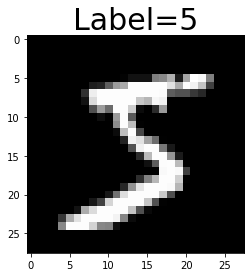

In [ ]:
train_dataset = datasets.MNIST('data/mnist',
        train=True,
        download=True,
        transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,))]))#.train_data



X = train_dataset.train_data.view(-1, 28*28)
y = train_dataset.targets

plt.title(f'Label={y[0]}', size=30)
plt.imshow(X[0].view(28, 28), cmap='gray');

In [94]:
dataset = datasets.MNIST('data/mnist',
        train=False,
        download=True,
        transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,))]))

dataset.data.shape

torch.Size([10000, 28, 28])

In [146]:
def mnist_private_pca(epsilon=4):
    train = datasets.MNIST('data/mnist',
            train=True,
            download=True,
            transform=transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))]))#.train_data

    test = datasets.MNIST('data/mnist',
            train=False,
            download=True,
            transform=transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))]))#.train_data

    X_train = train.data.view(-1, 28*28)
    y_train = train.targets

    X_test = test.data.view(-1, 28*28)
    y_test = test.targets

    DPPCA = diffprivlib.models.pca.PCA(n_components=60,centered=True, epsilon=epsilon)
    X_train_pc = DPPCA.fit_transform(X_train)
    X_train_pc = torch.Tensor(X_train_pc).view(-1, 60)

    X_test_pc = DPPCA.transform(X_test)
    X_test_pc = torch.Tensor(X_test_pc).view(-1, 60)
    return X_train_pc, y_train, X_test_pc, y_test




In [185]:
import tqdm

class simpleClf(nn.Module):
    def __init__(self, device='cpu'):
        super(simpleClf, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.model(x)

def train(dataloader, optimizer, clf, loss_function, epochs=3):
    
    epochs_ = range(epochs)
    for _ in epochs_:
        running_loss = 0
        for X, y in dataloader:
            optimizer.zero_grad()
            prediction = clf(X)
            loss = loss_function(prediction, y)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            print("Training loss: ",(running_loss/len(dataloader))) 
            

In [ ]:
X_train, y_train, X_test, y_test = mnist_private_pca(epsilon=100)
mnist_train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=True)
model = simpleClf()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

train(
    mnist_train_loader,
    optimizer=optimizer,
    clf=model,
    loss_function=criterion,
    epochs=5
    )

with torch.no_grad():
    logps = model(X_test.view(-1, 60))
print(f"Accuracy: {round(((torch.exp(logps).argmax(dim=1) == y_test).sum().float()/len(X_test)*100).item(), 2)}%")

In [196]:
import numpy as np

def test_pca():
    epsilons = np.linspace(0.00001, 10000, 9)
    accuracies = []
    for e in epsilons:
        X_train, y_train, X_test, y_test = mnist_private_pca(epsilon=e)
        mnist_train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
        mnist_test_loader = torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=True)
        model = simpleClf()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001)

        train(
            mnist_train_loader,
            optimizer=optimizer,
            clf=model,
            loss_function=criterion,
            epochs=5
            )

        with torch.no_grad():
            logps = model(X_test.view(-1, 60))
        accuracies.append(round(((torch.exp(logps).argmax(dim=1) == y_test).sum().float()/len(X_test)*100).item(), 2))
    return epsilons, accuracies

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

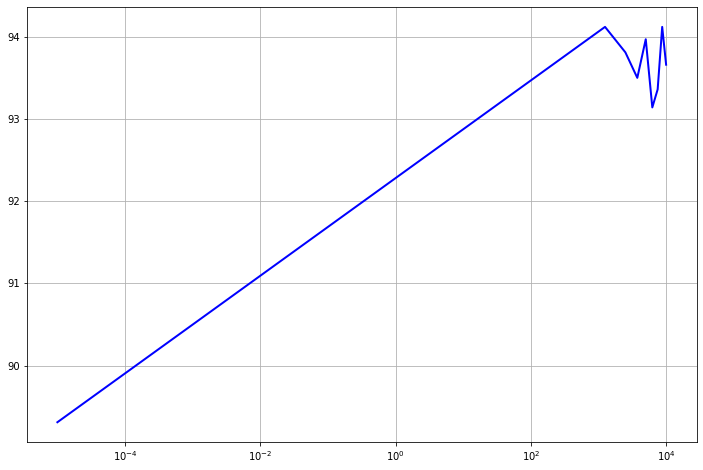

In [214]:


# eps, acc = test_pca()
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(eps, acc, color='blue', lw=2)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.grid()
plt.show()

In [162]:
X[0].shape

torch.Size([1, 60])

In [ ]:
import time
l = tqdm.tqdm((X, y))
for (x, y) in l:
    time.sleep(0.1)



  0%|          | 0/2 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
import sys

import argparse
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

from pyvacy import optim, analysis, sampling


# Deterministic output
torch.manual_seed(0)
np.random.seed(0)

class Flatten(nn.Module):
    def forward(self, inp):
        return inp.reshape(inp.shape[0], -1)

class Classifier(nn.Module):
    def __init__(self, input_dim, device='cpu'):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 8, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.Conv2d(16, 32, 4, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            Flatten(),
            nn.Linear(288, 10),
            nn.LogSoftmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.model(x)

class simpleClf(nn.Module):
    def __init__(self, input_dim, device='cpu'):
        super(simpleClf, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(60, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            nn.LogSoftmax(dim=1)
        ).to(device)

    def forward(self, x):
        return self.model(x)


def train(params):
    # train_dataset = datasets.MNIST('data/mnist',
    #     train=True,
    #     download=True,
    #     transform=transforms.Compose([
    #        transforms.ToTensor(),
    #        transforms.Normalize((0.5,), (0.5,))
    #     ])
    # )
    train_dataset = Xp

    classifier = simpleClf(
        # input_dim=np.prod(train_dataset[0][0].shape),
        input_dim = 60,
        device=params['device']
    )

    optimizer = optim.DPSGD(
        l2_norm_clip=params['l2_norm_clip'],
        noise_multiplier=params['noise_multiplier'],
        minibatch_size=params['minibatch_size'],
        microbatch_size=params['microbatch_size'],
        params=classifier.parameters(),
        lr=params['lr'],
        weight_decay=params['l2_penalty'],
    )

    print('Achieves ({}, {})-DP'.format(
        analysis.epsilon(
            len(train_dataset),
            params['minibatch_size'],
            params['noise_multiplier'],
            params['iterations'],
            params['delta']
        ),
        params['delta'],
    ))

    loss_function = nn.NLLLoss()

    minibatch_loader, microbatch_loader = sampling.get_data_loaders(
        params['minibatch_size'],
        params['microbatch_size'],
        params['iterations']
    )

    iteration = 0
    for X_minibatch, y_minibatch in minibatch_loader(TensorDataset(Xp, y)):
    # for X_minibatch, y_minibatch in minibatch_loader(train_dataset):

        optimizer.zero_grad()
        for X_microbatch, y_microbatch in microbatch_loader(TensorDataset(X_minibatch, y_minibatch)):
            X_microbatch = X_microbatch.to(params['device'])
            y_microbatch = y_microbatch.to(params['device'])
  
            optimizer.zero_microbatch_grad()
            pred = classifier(X_microbatch)#.argmax(dim=2)
            print(X_microbatch, pred, y_microbatch)
            loss = loss_function(pred.view(1, 10).float(), y_microbatch)
            print(loss)
            break
            loss.backward()
            optimizer.microbatch_step()
        optimizer.step()

        if iteration % 10 == 0:
            print('[Iteration %d/%d] [Loss: %f]' % (iteration, params['iterations'], loss.item()))
        iteration += 1

    return classifier



params = {
'delta': 1e-5,
'device': 'cpu',
'iterations': 14000,
'l2_norm_clip': 1.,
'l2_penalty':0.001, 
'lr': 0.15,
'microbatch_size':1,
'minibatch_size':256,
'noise_multiplier':1.1}

classifier = train(params)

with open('dp_classifier.dat', 'wb') as f:
    torch.save(classifier, f)

test_dataset = datasets.MNIST('data/mnist',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

X, y = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset))))
X, y  = X.to('cuda'), y.to('cuda')

y_pred = classifier(X).max(1)[1]

count = 0.
correct = 0.
for pred, actual in zip(y_pred, y):
    if pred.item() == actual.item():
        correct += 1.
    count += 1.
print('Test Accuracy: {}'.format(correct / count))


Achieves (3.001484703654448, 1e-05)-DP
tensor([[[1687.8270,  -27.6370, -234.4076, -266.1989,  458.8726, -459.3125,
            49.4550,  414.9841,   73.7365,  257.8884, -417.3697,    8.5458,
          -151.2217, -264.7183, -273.7069,  163.3416,  429.3411,   64.4026,
           -33.8287, -201.7081, -459.6727,   55.5027, -326.0295,  379.1437,
           334.2971,  -85.1494,  -64.2280,  -77.3139, -160.3390,   75.2707,
            -6.2583,  186.5017, -142.1675,  170.6958, -424.6932, -121.7693,
           135.5125,  119.6756,  158.1014,  -14.2701, -186.3714,  -91.5073,
          -241.6966,   37.4189,   43.8015,   49.5008,   84.6287,   84.7137,
            69.4251, -174.8053,   78.0787,  151.1046, -124.2576,   47.2992,
           -38.6829,  -30.3598,  146.3357,   48.1629,   84.9712,  -60.5954]]]) tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<LogSoftmaxBackward>) tensor([3])
tensor(0., grad_fn=<NllLossBackward>)


AttributeError: ignored

NameError: ignored

In [ ]:
[]

tensor(0.)

In [ ]:
    minibatch_loader, microbatch_loader = sampling.get_data_loaders(
        params['minibatch_size'],
        params['microbatch_size'],
        params['iterations']
    )
train_dataset = datasets.MNIST('data/mnist',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))]))
    



    for X_minibatch, y_minibatch in minibatch_loader(train_dataset):
        print(X_minibatch.shape, y_minibatch.shape)
        for X_microbatch, y_microbatch in microbatch_loader(TensorDataset(X_minibatch, y_minibatch)):
            print(X_microbatch.shape, y_microbatch.shape)
            break
        break



torch.Size([281, 1, 28, 28]) torch.Size([281])
torch.Size([1, 1, 28, 28]) torch.Size([1])


In [ ]:
train_dataset.train_data[0]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   